In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GRU, Dense, Dropout, BatchNormalization,Bidirectional, LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
# Load CSV
df = pd.read_csv("../Datasets/CSV_DATASET/gait_keypoints.csv")

In [3]:
df

,K0_x,K0_y,K0_z,K0_visibility,K1_x,K1_y,K1_z,K1_visibility,K2_x,K2_y,...,K30_visibility,K31_x,K31_y,K31_z,K31_visibility,K32_x,K32_y,K32_z,K32_visibility,label
0,0.544438,0.311799,-0.491928,0.999985,0.550760,0.302966,-0.457777,0.999956,0.554709,0.302936,...,0.727806,0.558707,0.712873,0.147720,0.975578,0.469627,0.707786,0.103613,0.960170,0
1,0.544429,0.312831,-0.539714,0.999986,0.550742,0.303536,-0.507108,0.999956,0.554873,0.303603,...,0.736965,0.560770,0.713326,0.123384,0.975932,0.469267,0.707753,0.095728,0.961618,0
2,0.544420,0.313358,-0.536183,0.999986,0.550721,0.303807,-0.503395,0.999956,0.554974,0.303904,...,0.745172,0.562135,0.713639,0.126704,0.976206,0.468989,0.707734,0.086965,0.962904,0
3,0.544412,0.313716,-0.552992,0.999986,0.550704,0.304033,-0.519973,0.999957,0.555055,0.304152,...,0.752738,0.563478,0.714173,0.144464,0.976483,0.468926,0.707861,0.089896,0.964261,0
4,0.544409,0.313985,-0.541478,0.999986,0.550690,0.304216,-0.508349,0.999957,0.555118,0.304348,...,0.759676,0.563592,0.714303,0.138728,0.976682,0.467939,0.707868,0.091107,0.965331,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,0.670237,-0.185817,0.010160,0.990551,0.637036,-0.201674,-0.102652,0.988985,0.622021,-0.201377,...,0.871135,0.461177,0.589925,1.202271,0.847898,0.703530,0.678279,1.041932,0.757861,4
1939,0.671349,-0.166190,-0.003337,0.991454,0.642305,-0.178645,-0.109127,0.990045,0.627943,-0.177255,...,0.877085,0.465175,0.596421,1.105750,0.846985,0.702633,0.673174,1.048200,0.760549,4
1940,0.655922,-0.165993,0.029245,0.992248,0.627492,-0.178381,-0.085604,0.990983,0.612966,-0.176982,...,0.883612,0.461193,0.599115,0.979052,0.845224,0.699980,0.670868,0.979459,0.766323,4
1941,0.618458,-0.155417,0.016472,0.992729,0.592696,-0.167426,-0.098251,0.991574,0.579236,-0.165696,...,0.889047,0.443759,0.592449,1.042519,0.840276,0.698442,0.672979,0.998246,0.769659,4


## Data splitting

In [4]:
new_df = df

X = new_df.iloc[:, :-1].values  
y = new_df['label'].values      


# x= independent , y output
new_df_scaler = StandardScaler()     
X = new_df_scaler.fit_transform(X)


X = X.reshape(X.shape[0], 33, 4) 


num_classes = len(np.unique(y))
y = to_categorical(y, num_classes)



New_X_train, New_X_test, New_y_train, New_y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)




In [5]:
with open("../Models/scaler.pkl", "wb") as f:
    pickle.dump(new_df_scaler, f)

## Model Creation and training

In [6]:
def create_CNN_LSTM_model(input_shape, num_classes):
    model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
            BatchNormalization(),

            Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
            BatchNormalization(),

            Bidirectional(LSTM(128, return_sequences=False)),

            Dense(64, activation='relu'),
            Dropout(0.4),  
            Dense(num_classes, activation='softmax') 
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [7]:
def create_CNN_GRU_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        Bidirectional(GRU(128, return_sequences=False)),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [8]:
def create_RNN_model(input_shape, num_classes):
    model = Sequential([
        SimpleRNN(128, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dense, Dropout, LSTM, Input, Bidirectional, Reshape

def create_autoencoder(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = Bidirectional(LSTM(128, return_sequences=False))(x)
    
    x = Dense(128, activation='relu')(encoded)
    x = Dense(input_shape[0] * input_shape[1], activation='sigmoid')(x)
    decoded = Reshape((input_shape[0], input_shape[1]))(x)  # Fix applied here
    
    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, encoder

def create_classification_model(encoder, num_classes):
    inputs = encoder.input
    x = encoder.output
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

autoencoder, encoder = create_autoencoder((33, 4))
classification_model = create_classification_model(encoder, num_classes)


In [10]:
models = {
    'CNN_GRU': create_CNN_GRU_model((33, 4), num_classes),
    'RNN': create_RNN_model((33, 4), num_classes),
    'CNN_LSTM': create_CNN_LSTM_model((33, 4), num_classes),
    'Autoencoder_Classifier': classification_model
}

C:\Users\Pramod Rai\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Pramod Rai\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
import json
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

results = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Callbacks for better training
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(f'../Models/{model_name}.h5', save_best_only=True)
    ]

    history = model.fit(New_X_train, New_y_train, epochs=15, batch_size=64, 
                        validation_data=(New_X_test, New_y_test), verbose=1, callbacks=callbacks)

    test_loss, test_acc = model.evaluate(New_X_test, New_y_test, verbose=1)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")

    # Save training history
    with open(f'../Models/{model_name}_history.json', 'w') as f:
        json.dump(history.history, f)

    results[model_name] = {
        'model': model,
        'history': history.history,  # Convert history to a dictionary
        'test_accuracy': test_acc
    }


Training CNN_GRU...
Epoch 1/15
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5426 - loss: 1.1396

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.5545 - loss: 1.1139 - val_accuracy: 0.6041 - val_loss: 1.1910
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8642 - loss: 0.3728

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8650 - loss: 0.3708 - val_accuracy: 0.7147 - val_loss: 0.9802
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9421 - loss: 0.2000

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9422 - loss: 0.1995 - val_accuracy: 0.6992 - val_loss: 0.8682
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9579 - loss: 0.1219 - val_accuracy: 0.6375 - val_loss: 0.8912
Epoch 5/15
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9649 - loss: 0.1087

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9650 - loss: 0.1082 - val_accuracy: 0.7789 - val_loss: 0.6372
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9765 - loss: 0.0783

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9765 - loss: 0.0782 - val_accuracy: 0.8072 - val_loss: 0.4958
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9769 - loss: 0.0781

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9770 - loss: 0.0778 - val_accuracy: 0.7943 - val_loss: 0.4702
Epoch 8/15
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9861 - loss: 0.0576

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9863 - loss: 0.0566 - val_accuracy: 0.8432 - val_loss: 0.3795
Epoch 9/15
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9962 - loss: 0.0255

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9962 - loss: 0.0252 - val_accuracy: 0.9409 - val_loss: 0.1714
Epoch 10/15
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9935 - loss: 0.0193

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9937 - loss: 0.0192 - val_accuracy: 0.9409 - val_loss: 0.1341
Epoch 11/15
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9999 - loss: 0.0137

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9998 - loss: 0.0136 - val_accuracy: 0.9640 - val_loss: 0.1071
Epoch 12/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9963 - loss: 0.0151 - val_accuracy: 0.9383 - val_loss: 0.1739
Epoch 13/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9979 - loss: 0.0098

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9978 - loss: 0.0098 - val_accuracy: 0.9871 - val_loss: 0.0514
Epoch 14/15
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9928 - loss: 0.0179

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9929 - loss: 0.0177 - val_accuracy: 0.9820 - val_loss: 0.0431
Epoch 15/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9978 - loss: 0.0111

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9977 - loss: 0.0111 - val_accuracy: 0.9923 - val_loss: 0.0228
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9894 - loss: 0.0230
CNN_GRU Test Accuracy: 0.9923
Training RNN...
Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3472 - loss: 1.4916 

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.3507 - loss: 1.4874 - val_accuracy: 0.5347 - val_loss: 1.1156
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5552 - loss: 1.0581

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5569 - loss: 1.0546 - val_accuracy: 0.6915 - val_loss: 0.7404
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7355 - loss: 0.7011

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7362 - loss: 0.6995 - val_accuracy: 0.8201 - val_loss: 0.5405
Epoch 4/15
19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8023 - loss: 0.5202

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8076 - loss: 0.5114 - val_accuracy: 0.8252 - val_loss: 0.4298
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8443 - loss: 0.4340

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8449 - loss: 0.4322 - val_accuracy: 0.8869 - val_loss: 0.3162
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8591 - loss: 0.3760 - val_accuracy: 0.8792 - val_loss: 0.3319
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9055 - loss: 0.2705

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9052 - loss: 0.2707 - val_accuracy: 0.9332 - val_loss: 0.2123
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9028 - loss: 0.2692 - val_accuracy: 0.9177 - val_loss: 0.2195
Epoch 9/15
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9216 - loss: 0.2326

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9220 - loss: 0.2307 - val_accuracy: 0.9640 - val_loss: 0.1248
Epoch 10/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9397 - loss: 0.1870 - val_accuracy: 0.9383 - val_loss: 0.1510
Epoch 11/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9337 - loss: 0.1791

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9341 - loss: 0.1785 - val_accuracy: 0.9512 - val_loss: 0.1132
Epoch 12/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9555 - loss: 0.1232 - val_accuracy: 0.9589 - val_loss: 0.1232
Epoch 13/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9451 - loss: 0.1467 - val_accuracy: 0.9383 - val_loss: 0.2311
Epoch 14/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9303 - loss: 0.2282 - val_accuracy: 0.9409 - val_loss: 0.1425
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9409 - loss: 0.1281 
RNN Test Accuracy: 0.9512
Training CNN_LSTM...
Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5778 - loss: 1.1209

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.5830 - loss: 1.1099 - val_accuracy: 0.6607 - val_loss: 1.1116
Epoch 2/15
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8687 - loss: 0.3888

OSError: [Errno 22] Unable to synchronously create file (unable to open file: name = '../Models/CNN_LSTM.h5', errno = 22, error message = 'Invalid argument', flags = 13, o_flags = 302)

## Ploting the Accuray Loss & Cofusion Matrix


Results for CNN_GRU:
Test Accuracy: 0.9974


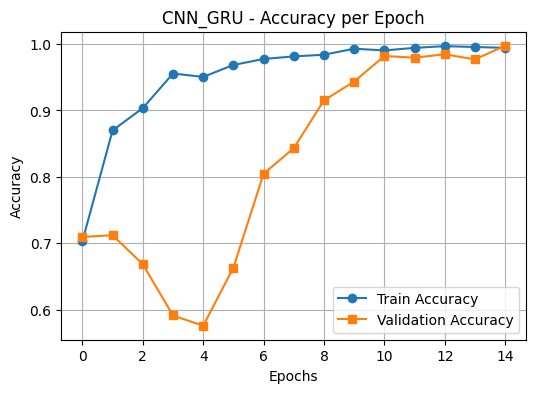

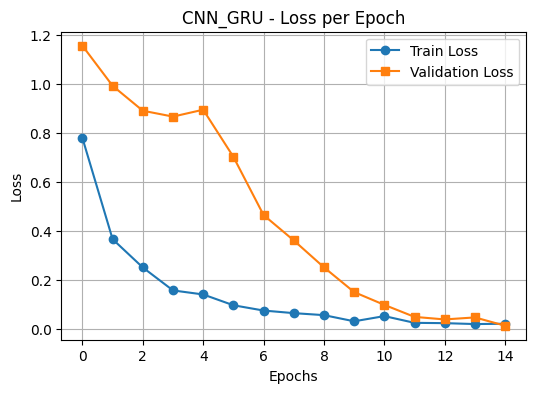


Results for RNN:
Test Accuracy: 0.9512


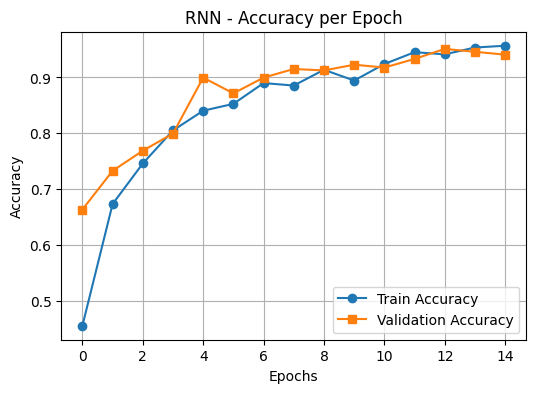

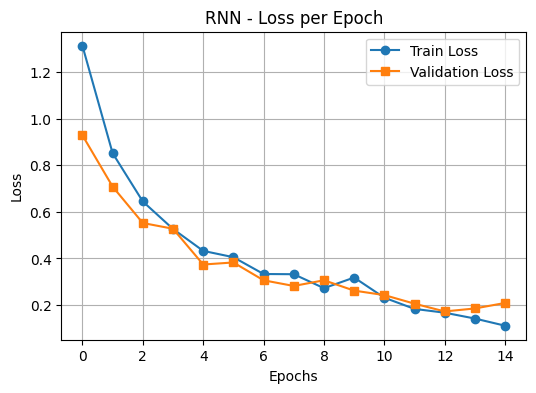


Results for CNN_LSTM:
Test Accuracy: 0.9820


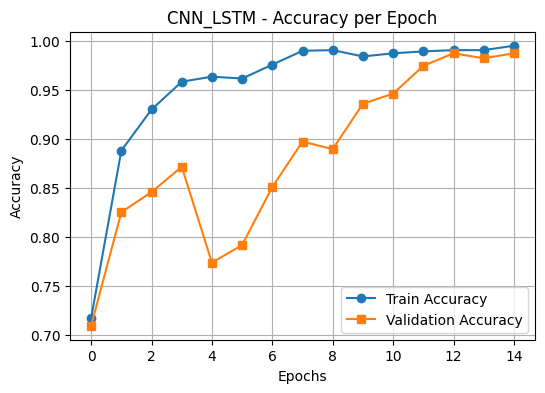

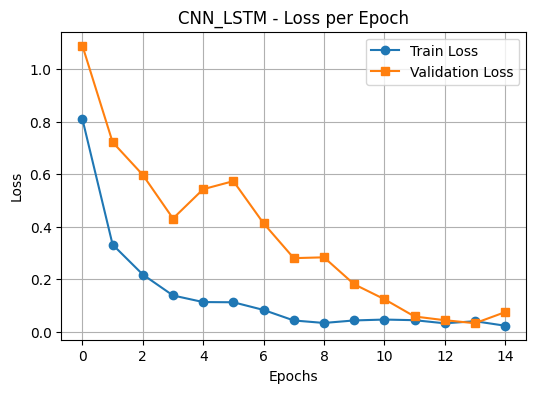


Results for Autoencoder_Classifier:
Test Accuracy: 1.0000


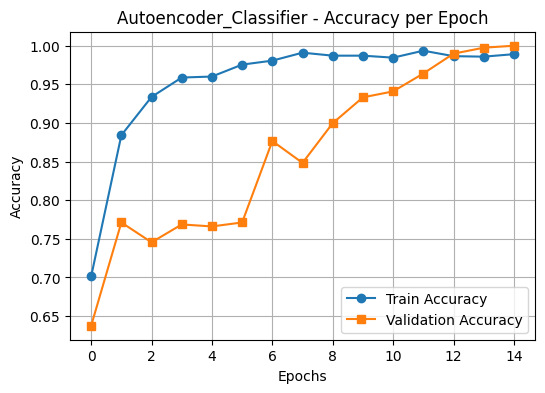

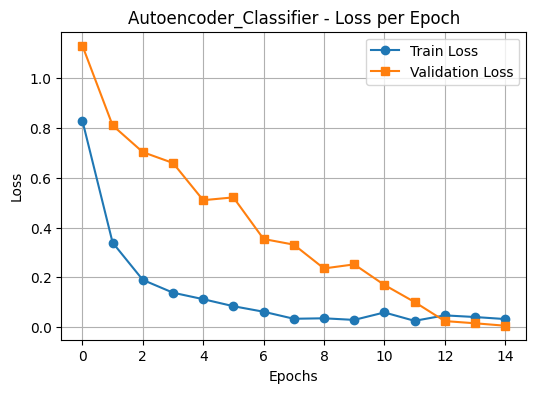

In [ ]:
import matplotlib.pyplot as plt

for model_name, result in results.items():
    print(f"\nResults for {model_name}:")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    
    history = result['history']  # history is already a dictionary

    # Plot Training & Validation Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Training & Validation Loss
    plt.figure(figsize=(6, 4))
    plt.plot(history['loss'], label='Train Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()


Loading and Evaluating CNN_GRU...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


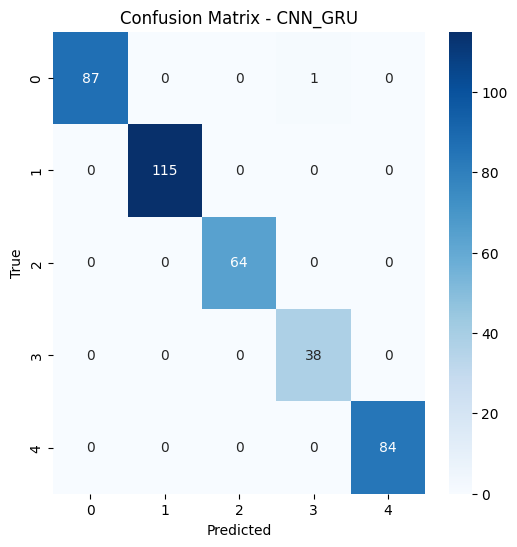

Classification Report for CNN_GRU:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       1.00      1.00      1.00       115
           2       1.00      1.00      1.00        64
           3       0.97      1.00      0.99        38
           4       1.00      1.00      1.00        84

    accuracy                           1.00       389
   macro avg       0.99      1.00      1.00       389
weighted avg       1.00      1.00      1.00       389


Loading and Evaluating RNN...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


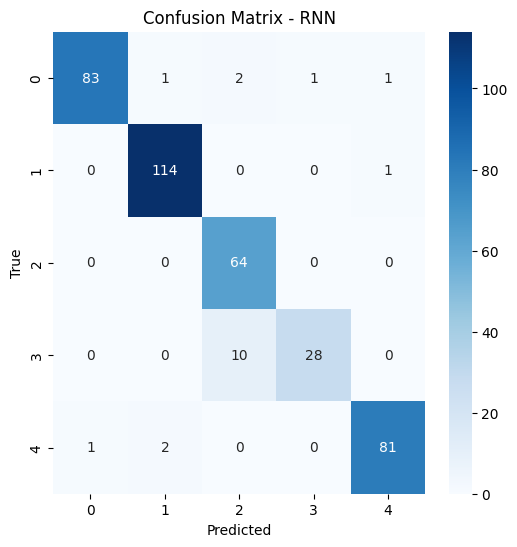

Classification Report for RNN:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97        88
           1       0.97      0.99      0.98       115
           2       0.84      1.00      0.91        64
           3       0.97      0.74      0.84        38
           4       0.98      0.96      0.97        84

    accuracy                           0.95       389
   macro avg       0.95      0.93      0.93       389
weighted avg       0.96      0.95      0.95       389


Loading and Evaluating CNN_LSTM...


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


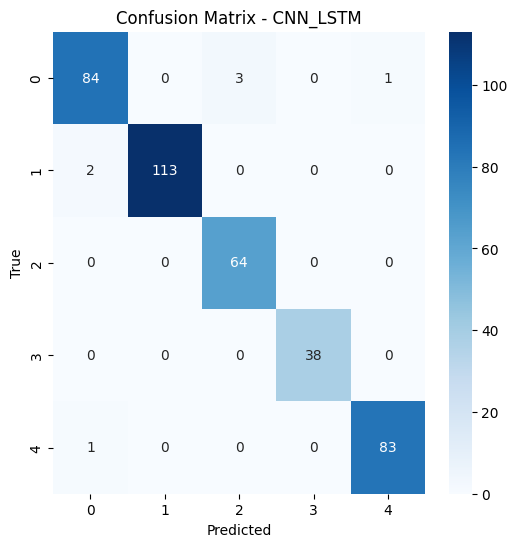

Classification Report for CNN_LSTM:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        88
           1       1.00      0.98      0.99       115
           2       0.96      1.00      0.98        64
           3       1.00      1.00      1.00        38
           4       0.99      0.99      0.99        84

    accuracy                           0.98       389
   macro avg       0.98      0.99      0.98       389
weighted avg       0.98      0.98      0.98       389


Loading and Evaluating Autoencoder_Classifier...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


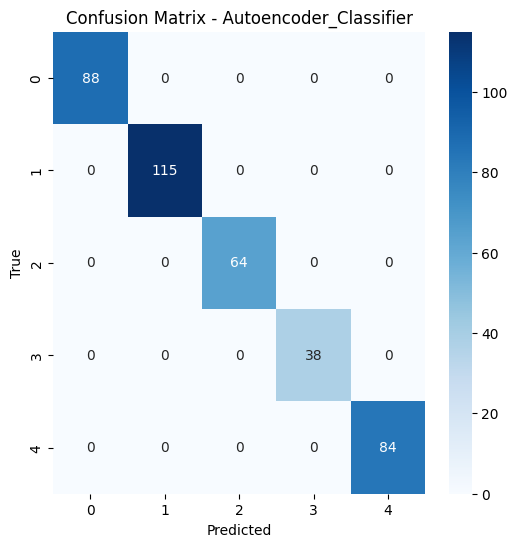

Classification Report for Autoencoder_Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       1.00      1.00      1.00       115
           2       1.00      1.00      1.00        64
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        84

    accuracy                           1.00       389
   macro avg       1.00      1.00      1.00       389
weighted avg       1.00      1.00      1.00       389




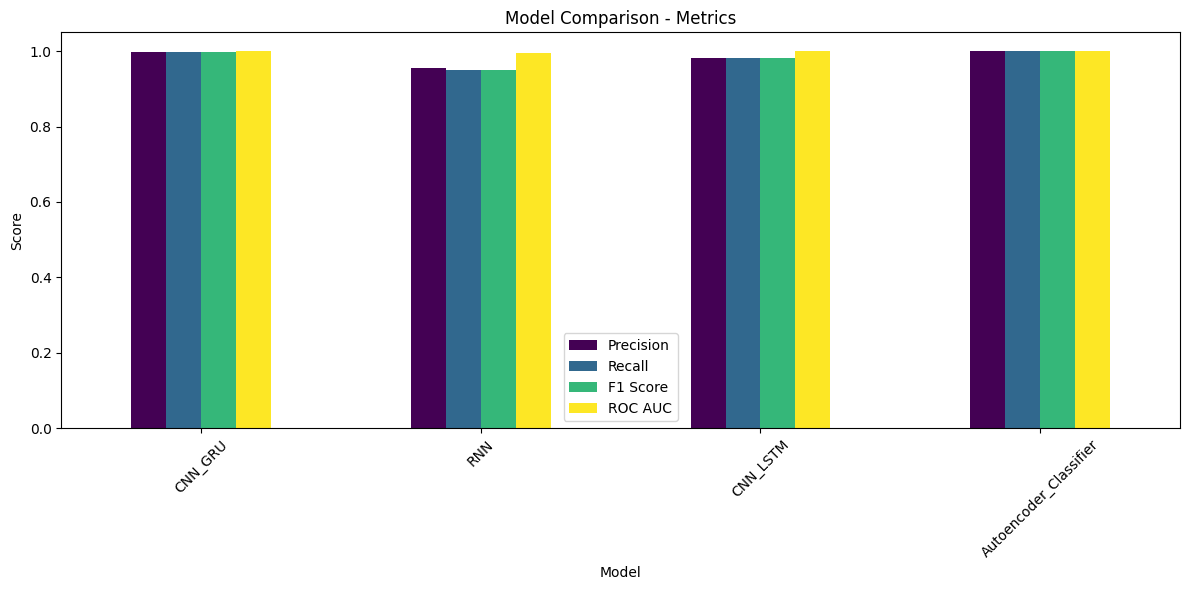

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score

# Function to evaluate each model and plot results
def evaluate_model(model, X_test, y_test, model_name, num_classes):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovr')
    
    class_report = classification_report(y_true, y_pred_classes)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return precision, recall, f1, roc_auc, class_report

# Function to plot model comparison metrics
def plot_comparison(metrics):
    metrics_df = pd.DataFrame(metrics).T
    metrics_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
    plt.title('Model Comparison - Metrics')
    plt.ylabel('Score')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Model file paths (Ensure these .h5 files exist)
models = {
    'CNN_GRU': '../Models/CNN_GRU.h5',
    'RNN': '../Models/RNN.h5',
    'CNN_LSTM': '../Models/CNN_LSTM.h5',
    'Autoencoder_Classifier': '../Models/Autoencoder_Classifier.h5'
}

# Ensure labels are correctly formatted
num_classes = 5  
if len(New_y_test.shape) > 1 and New_y_test.shape[1] == num_classes:
    y_test = New_y_test  # Already one-hot encoded
else:
    y_test = to_categorical(New_y_test, num_classes=num_classes)  # Convert labels to one-hot encoding

# Model evaluation
model_metrics = {}

for model_name, model_path in models.items():
    print(f"Loading and Evaluating {model_name}...")

    model = load_model(model_path)  # Load model using Keras

    precision, recall, f1, roc_auc, class_report = evaluate_model(model, New_X_test, y_test, model_name, num_classes)

    model_metrics[model_name] = {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    print(f"Classification Report for {model_name}:\n{class_report}\n")

# Plot the comparison of models
plot_comparison(model_metrics)


## Testing on Videos

In [ ]:
import pandas as pd
import cv2
import mediapipe as mp
import pickle
from sklearn.preprocessing import StandardScaler


In [ ]:
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils  # For drawing keypoints
pose = mp_pose.Pose()




# List to store extracted keypoints for saving
keypoints_data = []

def visualize_pose(video_path, max_frames=200, save_csv=True):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("❌ Error: Video file not found or could not be opened.")
        return

    print("✅ Video opened successfully!")

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame_count >= max_frames:
            break

        # Convert to RGB and process with MediaPipe Pose
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            print(f"🟢 Frame {frame_count}: Keypoints detected!")

            # Extract and store keypoints
            row = [frame_count]  # Start with frame number
            h, w, _ = frame.shape  # Get frame size

            for i, landmark in enumerate(results.pose_landmarks.landmark):
                cx, cy = int(landmark.x * w), int(landmark.y * h)  # Convert to pixel coordinates
                print(f"  Keypoint {i}: x={landmark.x:.4f}, y={landmark.y:.4f}, z={landmark.z:.4f}, visibility={landmark.visibility:.4f}")
                
                # Store for CSV
                row.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])
                
                # Overlay keypoint indices on the frame
                cv2.putText(frame, str(i), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 
                            0.5, (0, 255, 0), 2, cv2.LINE_AA)

            # Draw pose landmarks
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Save keypoints data
            if save_csv:
                keypoints_data.append(row)

        else:
            print(f"🔴 Frame {frame_count}: No keypoints detected.")

        cv2.imshow("Pose Visualization", frame)
        frame_count += 1

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    print("✅ Video processing completed!")

    # Save keypoints to CSV
    if save_csv and keypoints_data:
        columns =["Frame"] + [f"K{i}_{c}" for i in range(33) for c in ("x", "y", "z", "visibility")]
        LR_test_keypoints = pd.DataFrame(keypoints_data, columns=columns)
        LR_test_keypoints.to_csv("../Datasets/CSV_DATASET/pose_keypoints.csv", index=False)
        print("📂 Keypoints saved to pose_keypoints.csv")

visualize_pose("../Datasets/Test_videos/Normal Gait (1) copy.mp4")


✅ Video opened successfully!
🟢 Frame 0: Keypoints detected!
  Keypoint 0: x=0.4965, y=0.0452, z=-0.1584, visibility=0.9843
  Keypoint 1: x=0.5227, y=0.0338, z=-0.1988, visibility=0.9881
  Keypoint 2: x=0.5286, y=0.0347, z=-0.1990, visibility=0.9885
  Keypoint 3: x=0.5345, y=0.0357, z=-0.1991, visibility=0.9890
  Keypoint 4: x=0.5173, y=0.0335, z=-0.1349, visibility=0.9844
  Keypoint 5: x=0.5177, y=0.0341, z=-0.1350, visibility=0.9851
  Keypoint 6: x=0.5183, y=0.0348, z=-0.1352, visibility=0.9900
  Keypoint 7: x=0.5647, y=0.0534, z=-0.2837, visibility=0.9881
  Keypoint 8: x=0.5449, y=0.0516, z=-0.0007, visibility=0.9913
  Keypoint 9: x=0.5067, y=0.0666, z=-0.1814, visibility=0.9794
  Keypoint 10: x=0.4952, y=0.0663, z=-0.0996, visibility=0.9809
  Keypoint 11: x=0.5751, y=0.1602, z=-0.3843, visibility=0.9961
  Keypoint 12: x=0.5437, y=0.1418, z=0.2064, visibility=0.9968
  Keypoint 13: x=0.5139, y=0.2979, z=-0.3508, visibility=0.5317
  Keypoint 14: x=0.4622, y=0.2453, z=0.3804, visibility

In [ ]:
keypoints = pd.read_csv('../Datasets/CSV_DATASET/pose_keypoints.csv')

In [ ]:
import pickle
# Load the scaler
with open("../Models/scaler.pkl", "rb") as f:
    new_df_scaler = pickle.load(f)

In [ ]:
new_keypoints = keypoints.copy()
new_keypoints.drop("Frame", axis=1, inplace=True)

# Scale keypoints
new_keypoints = new_df_scaler.transform(new_keypoints)

# Reshape for CNN input
new_keypoints = new_keypoints.reshape(new_keypoints.shape[0], 33, 4)  # Ensure correct shape
print(f"✅ Extracted keypoints shape: {new_keypoints.shape}")
print(f"🔹 Sample keypoints (first frame):\n{new_keypoints[0]}")

✅ Extracted keypoints shape: (192, 33, 4)
🔹 Sample keypoints (first frame):
[[ 0.57691549 -0.75924843  0.09056614 -0.52251839]
 [ 0.74627682 -0.71167712 -0.12014871 -0.10196569]
 [ 0.78180027 -0.70379193 -0.12073374 -0.09620916]
 [ 0.81830646 -0.69550984 -0.12094705 -0.05431579]
 [ 0.72291558 -0.71426099  0.26497755 -0.24322423]
 [ 0.7326613  -0.70894154  0.26453189 -0.24200333]
 [ 0.74196719 -0.70300176  0.26388473 -0.03788206]
 [ 1.02930454 -0.62469483 -0.92889886  0.02399769]
 [ 0.92589465 -0.63860376  0.93358782 -0.02603631]
 [ 0.64820734 -0.74104935 -0.16118701 -1.12911656]
 [ 0.59469264 -0.74461241  0.36990542 -1.17994243]
 [ 1.05940778 -0.63519317 -1.90219733 -0.53994045]
 [ 0.9483515  -0.74385543  1.74601122 -1.1480046 ]
 [ 0.6724485  -0.62506269 -1.95408967  0.24833342]
 [ 0.54768235 -1.04727533  2.37856434 -2.58526783]
 [ 0.02123388 -1.74588303 -0.8856489  -0.30732483]
 [-0.1821914  -1.93855994  2.24201525 -2.19071771]
 [-0.16430596 -2.01590894 -0.78614322 -0.17897596]
 [-0.3

C:\Users\Pramod Rai\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
models = {
    'CNN_GRU': '../Models/CNN_GRU.h5',
    'RNN': '../Models/RNN.h5',
    'CNN_LSTM': '../Models/CNN_LSTM.h5',
    'Autoencoder_Classifier': '../Models/Autoencoder_Classifier.h5'
}
# Class labels
class_labels = {
    0: "Normal",
    1: "Limping",
    2: "Slouch",
    3: "No Arm Swing",
    4: "Concriduction"
}


In [ ]:
import numpy as np
from collections import Counter
from tensorflow.keras.models import load_model

# Iterate through models and show individual outputs
for model_name, model_path in models.items():
    print("\n" + "=" * 50)
    print(f"🔍 Evaluating Model: {model_name}")
    print("=" * 50)

    # Load model
    model = load_model(model_path)  # Use Keras load_model for .h5 files

    # Predict using the model
    predictions = model.predict(new_keypoints)
    predicted_classes = np.argmax(predictions, axis=1)

    # Store frame-wise predictions
    frame_predictions = [class_labels.get(pred, "Unknown") for pred in predicted_classes]

    # Count occurrences of each class
    counter = Counter(predicted_classes)

    # Find the most common class safely
    most_common_class = counter.most_common(1)
    overall_prediction = class_labels.get(most_common_class[0][0], "Unknown") if most_common_class else "No valid predictions"

    # Display class distribution
    print("\n📊 Class Distribution:")
    for key, value in counter.items():
        print(f"{class_labels.get(key, 'Unknown')}: {value} frames")

    # Display overall gait condition
    print(f"\n🚶 Overall Gait Condition (Most Common Prediction): {overall_prediction}")

print("\n✅ Multi-Model Gait Classification Completed.")


🔍 Evaluating Model: CNN_GRU


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  



📊 Class Distribution:
Limping: 48 frames
Normal: 117 frames
Concriduction: 25 frames
Slouch: 2 frames

🚶 Overall Gait Condition (Most Common Prediction): Normal

🔍 Evaluating Model: RNN
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  



📊 Class Distribution:
Limping: 133 frames
Normal: 36 frames
Concriduction: 23 frames

🚶 Overall Gait Condition (Most Common Prediction): Limping

🔍 Evaluating Model: CNN_LSTM
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 



📊 Class Distribution:
Concriduction: 17 frames
Normal: 158 frames
Limping: 13 frames
Slouch: 4 frames

🚶 Overall Gait Condition (Most Common Prediction): Normal

🔍 Evaluating Model: Autoencoder_Classifier
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

📊 Class Distribution:
Limping: 31 frames
Concriduction: 25 frames
Normal: 136 frames

🚶 Overall Gait Condition (Most Common Prediction): Normal

✅ Multi-Model Gait Classification Completed.
